In [415]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"


import celerite
from celerite import terms
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [416]:
def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase)
    
    return F

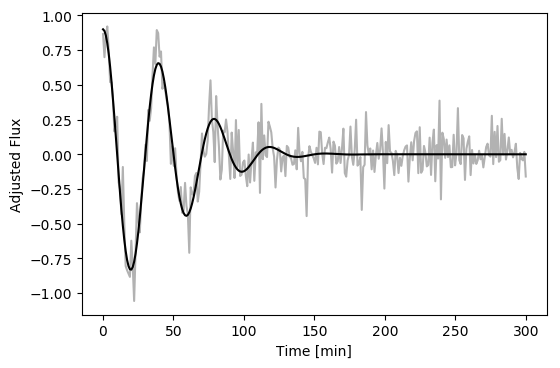

In [417]:
t = np.linspace(0, 300, 300)
QPP = qpp_model(t,0.9,0,50,40,0)
yerr = np.random.uniform(0.05, 0.2, len(t))

y = QPP + yerr * np.random.randn(len(t))
true_y = QPP

plt.plot(t, true_y, "k", lw=1.5)
plt.plot(t, y,'k',alpha=0.3)
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")



In [418]:
# Celerite SHO Kernel:

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel_1.freeze_parameter("log_Q")  

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel_1 += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
                        


In [419]:
# Custom Celerite kernel from Foreman-Mackey et al. 2017 & used in Angus et al. 2017

import autograd.numpy as np

class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), np.exp(log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) / (2.0 + b), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

bounds = dict(log_a=(None, None), log_b=(None, 5.0), log_c=(-1.0, 1.0),
              log_P=(-0.5, 0.5))
kernel_2 = CustomTerm(log_a=0.1, log_b=0.5, log_c=-0.01, log_P=0.0,
                    bounds=bounds)
                    


In [420]:
gp = celerite.GP(kernel_1, mean=np.mean(y))
gp.compute(t, yerr) 
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -79.30270645546605


In [421]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -146.85476585729845
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00084697, -0.00315481,  0.        ,  0.        ,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 29
   status: 0
  success: True
        x: array([-0.28338912, -2.01942685, -5.13677138, -6.207752  , -5.70242269])


In [422]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -0.28338911577365339),
             ('kernel:terms[0]:log_omega0', -2.0194268505833044),
             ('kernel:terms[1]:log_S0', -5.1367713757447806),
             ('kernel:terms[1]:log_Q', -6.2077519983545235),
             ('kernel:terms[1]:log_omega0', -5.7024226885449467)])

In [423]:
x = np.linspace(0, 300, 300)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

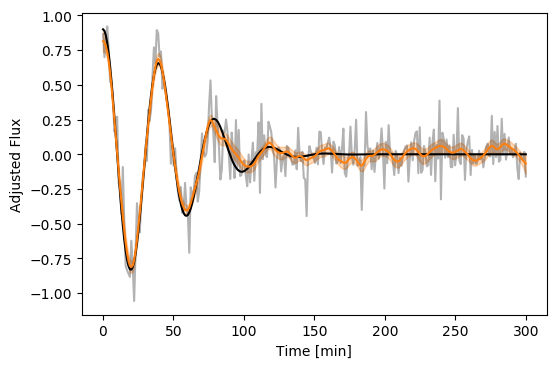

In [424]:
color = "#ff7f0e"
plt.plot(t, true_y, "k", lw=1.5)
plt.plot(t, y,'k',alpha=0.3)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")